In [41]:
#Importamos las librerías necesarias

from qiskit import QuantumCircuit, Aer, execute, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
import numpy as np

In [59]:
def diffuser(nqubits):#Grover gate
    qc = QuantumCircuit(nqubits)
    #qc.barrier(range(nqubits))
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    #qc.barrier(range(nqubits))
     #We will return the diffuser as a gate
    
    U_s = qc.to_gate()
    U_s.name = "Grover"
    #or as a circuit: qc
    return U_s
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc
def sudoku_oracle(qc,clause_list,clause_qubits,var_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, var_qubits[clause[0]], var_qubits[clause[1]], clause_qubits[i])
        i += 1
    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits,output_qubit)
    #Uncompute clauses
    i=0
    for clause in clause_list:
        XOR(qc, var_qubits[clause[0]], var_qubits[clause[1]], clause_qubits[i])
        i += 1
    qc.barrier(range(len(clause_qubits)+len(var_qubits)+1))
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

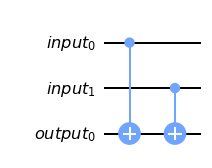

In [60]:
clause_list=[[0,1],
            [0,2],
            [1,3],
            [2,3]]

in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw(output="mpl")

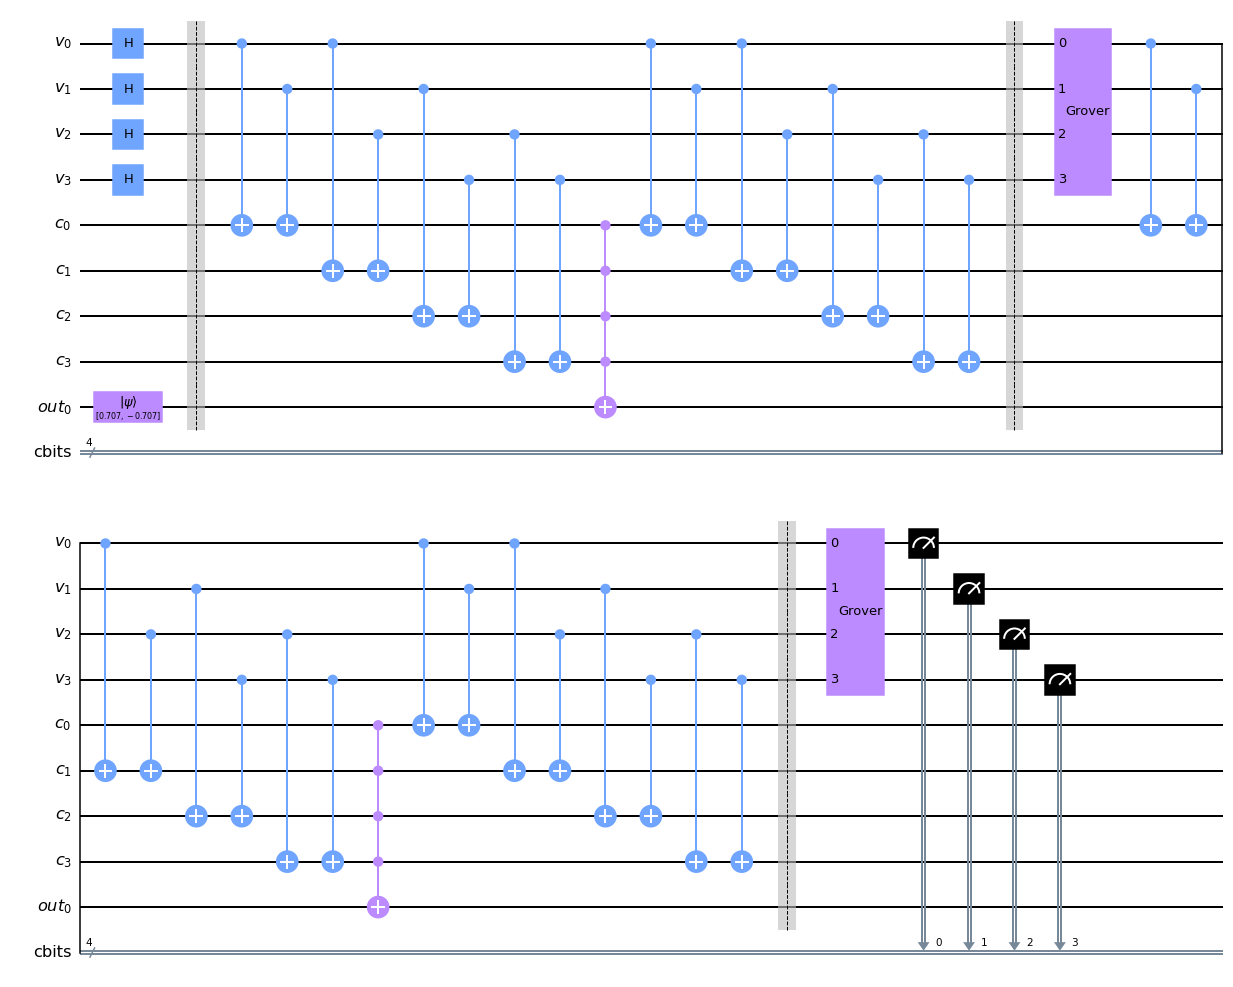

In [61]:
# Create separate registers to name bits
var_qubits=QuantumRegister(4,name='v')
clause_qubits=QuantumRegister(4,name='c')
output_qubit=QuantumRegister(1,name='out')
cbits=ClassicalRegister(4,name='cbits')
# Create quantum circuit
qc=QuantumCircuit(var_qubits,clause_qubits,output_qubit,cbits)

#Initialize the state out0:
qc.initialize([1,-1]/np.sqrt(2),output_qubit)
#Initialize the qubits in the |s> state:
initialize_s(qc,var_qubits)
qc.barrier(range(len(var_qubits)+len(clause_qubits)+1))

#Applying grover's algorithm (1st iteration):
#Applying the oracle
sudoku_oracle(qc,clause_list,clause_qubits,var_qubits)
#Applying the grover's gate
qc.append(diffuser(len(var_qubits)),var_qubits)

#Applying grover's algorithm (2nd iteration):
#Applying the oracle
sudoku_oracle(qc,clause_list,clause_qubits,var_qubits)
#Applying the grover's gate
qc.append(diffuser(len(var_qubits)),var_qubits)

#Measuring the state
qc.measure(var_qubits, cbits)

qc.draw(output="mpl")

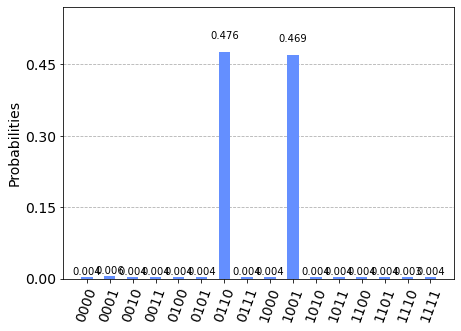

In [62]:
simulator=Aer.get_backend("qasm_simulator")
job=execute(qc,simulator,shots=10000)
result=job.result()
counts=result.get_counts()
plot_histogram(counts)